# ecoinvent efficiencies simulation

We want to change the "technosphere" and "biosphere" exchanges of an activity by scaling them down by a percentage (e.g. 10%) while keeping the "Production" exchange the same. This means that whila an activity originally required 10 kg of technosphere input A to produe 1 kg of production output B, then we need a function that creates a copy of this activity that only needs 9 kg of A to produce 1 kg of B. This will simulate an **improvement in efficiency** for the activity that might be due to e.g. **technology upsacling or learning** effects and is hyphotesized to be **non-linear**


## Import libraries

In [1]:
# Python libraries
# Data manipulation
import random
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2


In [2]:
#Local library
import brightway2 as bw

In [5]:
bw.projects.set_current("Massimo")
bw.databases

Databases dictionary with 2 object(s):
	biosphere3
	ecoinvent 3.6 cutoff

In [3]:
bw.projects.set_current('non-linearity')

In [4]:
#bw.bw2setup() # do only first time

In [4]:
bw.databases

Databases dictionary with 2 object(s):
	biosphere3
	ecoinvent 3.6 conseq

In [10]:
ei36dir = "/Users/massimo/Documents/Databases/ecoinvent v3.6/datasets"

if 'ecoinvent 3.6 conseq' in bw.databases: #this time im renaming the database i'll alter with _n
    print("Database has already been imported")
else:
    ei36 = bw.SingleOutputEcospold2Importer(ei36dir, 'ecoinvent 3.6 conseq')
    ei36.apply_strategies()
    ei36.statistics()
    ei36.write_database()

Extracting XML data from 16459 datasets
Extracted 16459 datasets in 52.35 seconds
Applying strategy: normalize_units
Applying strategy: update_ecoinvent_locations
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: fix_ecoinvent_flows_pre35
Applying strategy: drop_temporary_outdated_biosphere_flows
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
Applying strategy: delete_exchanges_missing_activity
Applying strategy: delete_ghost_exchanges
3 exchanges couldn't be linked and were deleted. See the logfile for details:
	/Users/massimo/Library/Logs/Brightway3/non-linearity.bff727cca2fd2c65bd9

Writing activities to SQLite3 database:


16459 datasets
467562 exchanges
0 unlinked exchanges
  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:41


Title: Writing activities to SQLite3 database:
  Started: 09/15/2020 18:28:17
  Finished: 09/15/2020 18:28:58
  Total time elapsed: 00:00:41
  CPU %: 91.00
  Memory %: 8.05
Created database: ecoinvent 3.6 conseq


# Part one
### Where we investigate the effect of progressively increasing the efficiency of the inputs of specific activities

We want to modify the efficiency of coal power plants.
We colect their codes.

In [9]:
looking_for = ["electricity", "production", "coal"]
forbidden = ["aluminium", "supercritical", "mine"]
coal_power_plants = [a.key for a in bw.Database("ecoinvent 3.6 conseq")
                     if all(x in a["name"] for x in looking_for)
                    and not any(x in a["name"] for x in forbidden)
                    and a["reference product"] == "electricity, high voltage"]

We want to examine the effect of efficiency change on a number of activities.

In [11]:
FU = [{bw.Database("ecoinvent 3.6 conseq").random():1} for a in range(10)]

In [12]:
l_res = []

# `x` will represent our efficiency increase factor.
# Here we start at 1 (meaning unmodified) and go down to .2, representing a efficiency increase of 400%, right? (1/.2)

for x in np.arange(1.0, .1, -.1):
    
    # We build a first time the technology matrix.
    
    LCA = bw.LCA(FU[0], ('IPCC 2013', 'climate change', 'GWP 100a'))
    LCA.lci()
    LCA.lcia()
    
    
    # We get the row numbers of the power plants on the technology matrix
    coal_pp_col = [LCA.activity_dict[a] for a in coal_power_plants]
    
    # We select the columns that correspond to the power plants in the tech matrix
    # And we decrease all the values row-wise by increment of 0.1, except for the values
    # in the diagonal (which represent the electricity output)
    
    LCA.technosphere_matrix[
        np.ix_([c for c in range(0, LCA.technosphere_matrix.shape[0]) if c not in coal_pp_col],
               coal_pp_col)] *= x
    
    # Then we iterate through our FUs
    
    for j, fu in enumerate(FU):
        LCA.redo_lci(fu)
        LCA.lcia()
        l_res.append(((1/x-1)*100, list(fu.keys())[0]["name"], LCA.score))

In [13]:
res = pd.DataFrame(l_res, columns=['PP efficiency increase (%)', 'Name', 'GWP'])\
    .groupby(["Name", "PP efficiency increase (%)"])[["GWP"]].sum()

Text(0.5, 0, 'Coal PP efficiency increase')

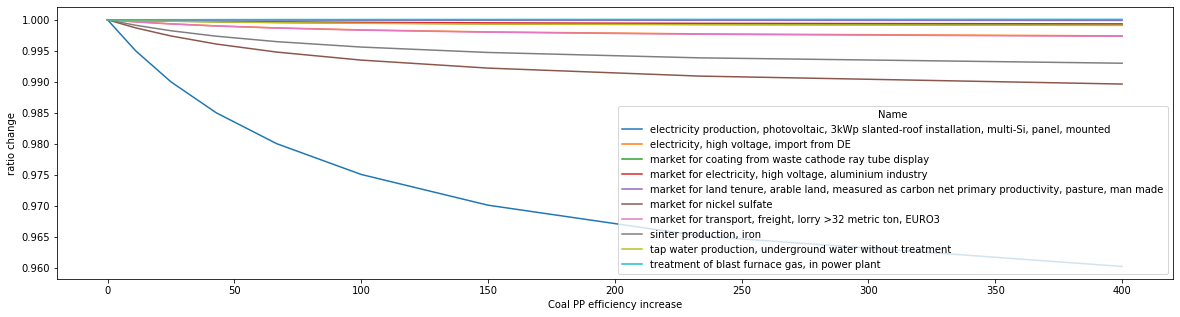

In [14]:
(res / pd.DataFrame(l_res, columns=['PP efficiency increase (%)', 'Name', 'GWP'])\
    .groupby(["Name"])[["GWP"]].first())["GWP"].unstack().T.plot(figsize=(20, 5))
plt.ylabel("ratio change")
plt.xlabel("Coal PP efficiency increase")

# Part two

### Where we study the more general effect of (randomly) increasing the efficiency of transformation activities

We look only at transformation activities, not market ones - because the transformation activities are those where you can have efficiency gains while the market ones are only a mix of transformation activities (the sum of which = 1) + transport, so not much to upscale there. So we filter the database to select only transformation activities. 

We will then select some **other** activities (market activities, ideally) and then analyze their impact (e.g. kg CO2-eq) both with the default version of the database and with the "improvement scenario" (specific inputs of the transformation activities reduced by a percentage) and then compare the difference, i.e. the **ration** between the two impact values expressed as a number between 0 and 1. The hyphothesis is that the improved version shuold have a lower impact than the default one.


In [6]:
mydb = bw.Database('ecoinvent 3.6 cutoff')

In [6]:
mydb = bw.Database('ecoinvent 3.6 conseq')

In [7]:
# Create list with all transforming activities in the database

transf_act = [act for act in mydb if 'ordinary transforming activity' in act['activity type']]

In [9]:
# Create a list of random activities to study

# Method 1, import a predefined list (for reproducibility)
#mysample = pd.read_csv('sample_codes.csv')['samplecodes'].values.tolist()  # this to get it back
#random_acts = [mydb.get(code) for code in mysample]

# Method 2, completely random selection
random_acts =  [mydb.random() for act in range(50)] # very coarse

# Method 3, selecte only among specific market activities (avoid treatment ones that have negative results)
#m_act = [act for act in mydb if 
#              ('market activity' in act['activity type'] and 
#               act['production amount'] > 0)] # exclude waste markets and treatment activities
#random_acts =  random.sample(m_act,50) # 

In [10]:
# extract lists of codes, names, and FUs for future use

l_names = [act['name'] for act in random_acts]
l_codes = [act['code'] for act in random_acts]  
FU = [{act:1} for act in random_acts] 

# dump this as a list for future use
#pd.DataFrame(l_codes).to_csv('sample_codes.csv', index=False, header = ['samplecodes'], sep = ';')

In [11]:
# calculate base values for the sample activities (before improving the efficiency of the transformation ones)

l_res_base = []

for j, fu in enumerate(FU): 
    LCA = bw.LCA(fu, ('IPCC 2013', 'climate change', 'GWP 100a'))
    LCA.lci()
    LCA.lcia()
    l_res_base.append(LCA.score) 
    
pd.DataFrame({'name' : l_names, 'code' :l_codes, 'GWP' : l_res_base}).head()

,name,code,GWP
0,"electricity production, photovoltaic, 3kWp sla...",9f5958c9659f2e0d33b99d2b5d62a07a,5.559413e-02
1,"electricity production, hard coal",f93e1189fd2d8dbf1ce7441fa99a3a15,1.010996e+00
2,"fattening of heifers for beef production, feedlot",1eb071a885a870cec1bb438bb9a91b5f,1.807938e+01
3,"treatment of used train, passenger, high-speed",87a361bf8be1abbcb0e3e615501a60af,-3.772085e+05
4,wood pellet factory production,7dad331db81e400e7cbbeebed53e5106,5.283364e+06


A key question is **how** to simulate potential efficiency gains.

We could do this completely randomly. One can improve an exchange input between 100% ( = no change) and 0% (no need for the input). Or in other words one can imagine that the database providers have reported an exchange that is far 0-100% from max efficiency (this is how much they could be "wrong" in terms of getting the right scale for the activity). Since **we don't know which exchanges can be improved** and where the upscaling uncertainty is, then we assume that "in general" most exchanges will be close to the max efficiency (ecoinvent database providers ask large established industries for data) and the probability of being wrong is decreasing i.e. a very few exchanges will be far-off from the max efficiency value and can be improved substantially, others can only be improved marginally. 

This could be modelled using a **beta distribution** that looks like an exponential distribution but is between 0 and 1 and is appropriate to model percentages. This would avoid the problem of choosing an efficiency gain (see part one of this notebook) and of assuming the same gain for all flows of an activity - both assumptions are too unrealistic.

(array([3.000e+00, 3.100e+01, 7.300e+01, 1.780e+02, 3.410e+02, 6.200e+02,
        1.046e+03, 1.664e+03, 2.440e+03, 3.604e+03]),
 array([0.14916892, 0.23425043, 0.31933194, 0.40441345, 0.48949496,
        0.57457647, 0.65965798, 0.74473949, 0.829821  , 0.91490251,
        0.99998402]),
 <a list of 10 Patch objects>)

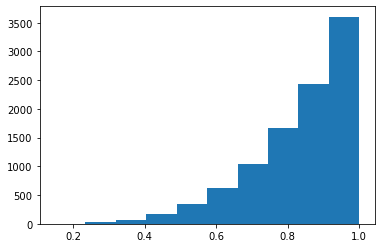

In [12]:
# The beta distribution used here

plt.hist(np.random.beta(5.0, 1.0, 10000))

In [45]:
transf_act

['lightweight concrete block production, polystyrene' (kilogram, RoW, None),
 'cottonseed oil refinery operation' (kilogram, RoW, None),
 'mowing, by motor mower' (hectare, CH, None),
 'inverter production, 500kW' (unit, RER, None),
 'electronic component machinery production, unspecified' (unit, GLO, None),
 'heat production, mixed logs, at furnace 30kW, state-of-the-art 2014' (megajoule, CH, None),
 'electricity production, oil' (kilowatt hour, CA-ON, None),
 'treatment of waste graphical paper, unsanitary landfill, moist infiltration class (300mm)' (kilogram, GLO, None),
 'treatment of waste wire plastic, municipal incineration with fly ash extraction' (megajoule, CH, None),
 'patagonian grenadier, capture by trawler and landing in fish blocks, frozen' (kilogram, RoW, None),
 'operation, solar collector system, evacuated tube collector, one-family house, for combined system' (megajoule, CA-QC, None),
 'electricity production, hydro, run-of-river' (kilowatt hour, CN-SH, None),
 'clin

In [157]:
bw.calculation_setups['multiLCA'] = {'inv': FU, 'ia': [('IPCC 2013', 'climate change', 'GWP 100a')]}
myMultiLCA = bw.MultiLCA('multiLCA')
l_res_base = myMultiLCA.results.reshape(len(FU))

In [171]:
# Simulation: improve the efficiency of transformation activities and calcualte impact of market activities

a, b = 5., 1. # coefficients for beta distribution

l_res_sim = [] # sim = simulation

for x in range(0, 100):   # twenty iterations, takes some time
    l_res_iter = []

    lca = bw.LCA(FU[0], ('IPCC 2013', 'climate change', 'GWP 100a'))
    lca.lci()
    lca.lcia()
    
    transf_col = [lca.activity_dict[a] for a in transf_act] # get column index of tranformation activities
    
    inds = np.where((np.isin(lca.tech_params["col"],transf_col))
                   &(lca.tech_params["col"]!=lca.tech_params["row"])
                   &(lca.tech_params["amount"]!=0))[0]
    
    vals = lca.tech_params["amount"].copy()
    
    vals[inds] *=  np.random.beta(a, b, len(vals[inds]))
    
    lca.rebuild_technosphere_matrix(vals)
    
    for fu in FU:
        lca.redo_lcia(fu)
        l_res_iter.append(lca.score)
        
    l_res_sim.append(l_res_iter)
    print(x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [172]:
# Put base and simulation values together in a dataframe

res_df = pd.concat([pd.DataFrame({'Base': l_res_base}, l_names) , 
                    pd.DataFrame(l_res_sim, columns = l_names).T], 
                   axis=1) # use names_list to get names instead
res_df

,Base,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,...,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
"electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, panel, mounted",5.559413e-02,1.989892e-02,9.150456e-03,1.559336e-02,1.076683e-02,2.209359e-02,2.218945e-02,1.556083e-02,1.516198e-02,1.902982e-02,2.099515e-02,1.988781e-02,1.300739e-02,1.572562e-02,1.517500e-02,2.247741e-02,1.306567e-02,2.565342e-02,2.138506e-02,1.803919e-02,1.753904e-02,6.722314e-03,1.521446e-02,1.391383e-02,1.960310e-02,...,1.733162e-02,1.817467e-02,1.471350e-02,9.060954e-03,1.617618e-02,2.112061e-02,1.057952e-02,1.771446e-02,1.510799e-02,1.897860e-02,1.555214e-02,2.137989e-02,1.239980e-02,1.541788e-02,2.074606e-02,1.516491e-02,1.709050e-02,1.493149e-02,1.161730e-02,5.894329e-03,1.558890e-02,1.893920e-02,1.541626e-02,2.099352e-02,1.747781e-02
"electricity production, hard coal",1.010996e+00,9.804235e-01,9.678007e-01,9.855261e-01,9.653164e-01,9.683740e-01,9.834069e-01,9.632772e-01,9.925649e-01,9.900852e-01,9.835908e-01,9.819355e-01,9.911058e-01,9.818842e-01,9.738284e-01,9.764288e-01,9.815244e-01,9.751632e-01,9.691454e-01,9.797542e-01,9.906441e-01,9.597709e-01,9.952390e-01,9.884265e-01,9.893300e-01,...,9.860840e-01,9.918298e-01,9.727235e-01,9.705166e-01,9.936358e-01,9.839622e-01,9.913878e-01,9.773366e-01,9.834995e-01,9.541457e-01,9.937534e-01,9.828349e-01,9.904927e-01,9.633012e-01,9.796343e-01,9.740127e-01,9.921671e-01,9.701202e-01,9.627093e-01,9.765758e-01,9.815802e-01,9.929879e-01,9.948492e-01,9.788391e-01,9.891769e-01
"fattening of heifers for beef production, feedlot",1.807938e+01,1.589759e+01,1.628723e+01,1.686822e+01,1.584305e+01,1.582497e+01,1.429178e+01,1.649200e+01,9.431696e+00,1.116696e+01,1.503903e+01,1.583592e+01,1.612583e+01,1.689330e+01,1.628037e+01,1.428334e+01,1.584006e+01,1.679893e+01,1.292640e+01,1.313376e+01,1.531711e+01,1.583349e+01,1.289325e+01,1.077520e+01,1.625455e+01,...,1.411535e+01,1.508660e+01,1.131061e+01,1.584149e+01,1.563726e+01,1.347002e+01,1.527337e+01,1.388666e+01,1.537570e+01,1.526493e+01,1.481990e+01,1.406039e+01,1.205678e+01,1.534964e+01,1.635129e+01,1.502589e+01,1.198691e+01,1.123111e+01,1.623335e+01,1.657364e+01,1.599282e+01,1.413551e+01,1.358731e+01,1.258270e+01,1.572378e+01
"treatment of used train, passenger, high-speed",-3.772085e+05,-3.452805e+05,-3.483431e+05,-2.723181e+05,-2.779765e+05,-3.348927e+05,-3.223294e+05,-3.577754e+05,-3.659578e+05,-3.579373e+05,-3.547819e+05,-3.328873e+05,-2.713951e+05,-3.522332e+05,-3.557626e+05,-3.006956e+05,-3.686589e+05,-3.639383e+05,-2.788035e+05,-3.444481e+05,-3.067039e+05,-3.292248e+05,-3.122893e+05,-2.930857e+05,-2.358678e+05,...,-3.655159e+05,-3.671715e+05,-3.114645e+05,-3.466860e+05,-3.308427e+05,-3.445443e+05,-3.035083e+05,-2.959670e+05,-1.248825e+05,-3.389929e+05,-3.054487e+05,-3.402276e+05,-2.166823e+05,-3.218490e+05,-3.662415e+05,-2.359394e+05,-3.087208e+05,-2.098107e+05,-3.675297e+05,-3.674016e+05,-2.456058e+05,-1.638829e+05,-3.203087e+05,-3.639190e+05,-3.620858e+05
wood pellet factory production,5.283364e+06,2.683090e+06,2.732468e+06,2.549500e+06,2.048527e+06,2.196924e+06,2.293467e+06,2.616243e+06,2.303928e+06,2.036452e+06,1.978565e+06,2.577544e+06,2.855474e+06,2.477269e+06,2.580160e+06,2.585313e+06,2.459300e+06,2.533327e+06,2.309040e+06,2.209321e+06,2.372301e+06,2.190350e+06,2.429779e+06,2.546782e+06,2.549645e+06,...,2.013239e+06,2.715412e+06,2.547410e+06,2.332193e+06,2.330214e+06,2.032526e+06,2.139729e+06,2.231111e+06,2.152453e+06,2.540793e+06,2.198545e+06,2.312135e+06,2.375372e+06,2.602927e+06,2.560277e+06,2.715763e+06,2.451181e+06,2.341294e+06,2.227324e+06,2.430708e+06,2.275786e+06,2.413666e+06,2.651427e+06,2.282307e+06,2.068568e+06
"electricity, high voltage, import from PT",3.705865e-01,2.590255e-01,2.632962e-01,3.459051e-01,2.641050e-01,3.030964e-01,2.796067e-01,3.415179e-01,3.308783e-01,2.594108e-01,2.862859e-01,3.239180e-01,3.406733e-01,1.124193e-01,3.168085e-01,2.973696e-01,2.585370e-01,3.0

In [173]:
# calculate the ratios between base value and simulation value
res_df_ratio = res_df.div(res_df.Base, axis=0).iloc[:,1:]
res_df_ratio

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
"electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, panel, mounted",0.357932,0.164594,0.280486,0.193668,0.397409,0.399133,0.279901,0.272726,0.342299,0.377651,0.357732,0.233971,0.282865,0.272960,0.404313,0.235019,0.461441,0.384664,0.324480,0.315484,0.120918,0.273670,0.250275,0.352611,0.363954,...,0.311753,0.326917,0.264659,0.162984,0.290969,0.379907,0.190299,0.318639,0.271755,0.341378,0.279744,0.384571,0.223041,0.277329,0.373170,0.272779,0.307416,0.268580,0.208966,0.106024,0.280406,0.340669,0.277300,0.377621,0.314382
"electricity production, hard coal",0.969760,0.957275,0.974808,0.954818,0.957842,0.972711,0.952801,0.981770,0.979317,0.972893,0.971256,0.980327,0.971205,0.963237,0.965809,0.970849,0.964557,0.958605,0.969098,0.979870,0.949332,0.984415,0.977676,0.978570,0.973878,...,0.975359,0.981043,0.962144,0.959961,0.982829,0.973261,0.980605,0.966707,0.972803,0.943768,0.982945,0.972146,0.979720,0.952824,0.968980,0.963419,0.981376,0.959569,0.952239,0.965955,0.970905,0.982188,0.984029,0.968193,0.978419
"fattening of heifers for beef production, feedlot",0.879322,0.900873,0.933009,0.876305,0.875305,0.790502,0.912200,0.521683,0.617663,0.831833,0.875911,0.891946,0.934396,0.900494,0.790035,0.876140,0.929177,0.714980,0.726450,0.847214,0.875776,0.713147,0.595994,0.899066,0.904095,...,0.780743,0.834465,0.625608,0.876219,0.864922,0.745049,0.844795,0.768094,0.850455,0.844328,0.819713,0.777703,0.666880,0.849014,0.904416,0.831107,0.663016,0.621211,0.897893,0.916715,0.884589,0.781858,0.751536,0.695970,0.869708
"treatment of used train, passenger, high-speed",0.915357,0.923476,0.721930,0.736931,0.887818,0.854513,0.948482,0.970174,0.948911,0.940546,0.882502,0.719483,0.933789,0.943146,0.797160,0.977334,0.964820,0.739123,0.913150,0.813088,0.872792,0.827896,0.776986,0.625298,0.862773,...,0.969002,0.973391,0.825709,0.919083,0.877082,0.913405,0.804617,0.784624,0.331070,0.898688,0.809761,0.901962,0.574436,0.853239,0.970926,0.625488,0.818435,0.556219,0.974341,0.974001,0.651114,0.434462,0.849155,0.964769,0.959909
wood pellet factory production,0.507837,0.517183,0.482552,0.387732,0.415819,0.434092,0.495185,0.436072,0.385446,0.374490,0.487860,0.540465,0.468881,0.488355,0.489331,0.465480,0.479491,0.437040,0.418166,0.449013,0.414575,0.459892,0.482038,0.482580,0.431913,...,0.381052,0.513955,0.482157,0.441422,0.441047,0.384703,0.404994,0.422290,0.407402,0.480904,0.416126,0.437626,0.449595,0.492665,0.484592,0.514022,0.463943,0.443145,0.421573,0.460068,0.430746,0.456843,0.501845,0.431980,0.391525
"electricity, high voltage, import from PT",0.698961,0.710485,0.933399,0.712668,0.817883,0.754498,0.921561,0.892851,0.700001,0.772521,0.874069,0.919281,0.303355,0.854884,0.802430,0.697643,0.831546,0.827569,0.875315,0.661226,0.681293,0.636800,0.680080,0.912091,0.824607,...,0.887660,0.748581,0.752620,0.850159,0.512142,0.861515,0.913207,0.350162,0.880252,0.919955,0.854045,0.801131,0.755929,0.623279,0.823262,0.828706,0.862183,0.712794,0.884139,0.734778,0.691714,0.714647,0.619384,0.751635,0.776416
"planing, lath, softwood, u=20%",0.383793,0.400269,0.522430,0.386478,0.402979,0.444352,0.367077,0.586942,0.480018,0.472132,0.358335,0.529446,0.576105,0.400412,0.491132,0.469034,0.445828,0.475213,0.361995,0.561684,0.347285,0.303941,0.391029,0.539481,0.279893,...,0.479326,0.303373,0.295957,0.537002,0.387505,0.392413,0.303982,0.428195,0.300895,0.474909,0.507771,0.443268,0.411561,0.338933,0.370332,0.527665,0.497919,0.389060,0.546222,0.493713,0.419386,0.553329,0.425316,0.411878,0.524566
"market for steel removed by milling, dressing",0.559772,0.522158,0.577420,0.518945,0.614401,0.488653,0.474814,0.601820,0.533570,0.551826,0.496346,0.525567,0.587965,0.508013,0.450518,0.571792,0.488175,0.525576,0.530068,0.540422,0.612878,0.553171,0.511850,0.568107,0.543418,...,0.494501,0.536397,0.567494,0.511027,0.488536,0.516364,0.57

In [174]:
# a check
df_base_check = res_df.iloc[:,0].div(res_df.Base, axis=0)
print(df_base_check[df_base_check == 1.0].count(), 'out of' , res_df.shape[0] , 'equals one')
print(df_base_check.isnull().sum(), 'out of' , res_df.shape[0] , 'is NaN')


47 out of 50 equals one
3 out of 50 is NaN


Text(0, 0.5, 'Frequency')

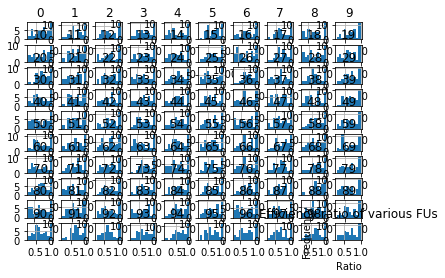

In [175]:
#plot all activities
res_df_ratio.hist()

plt.title('Efficiency ratio of various FUs')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

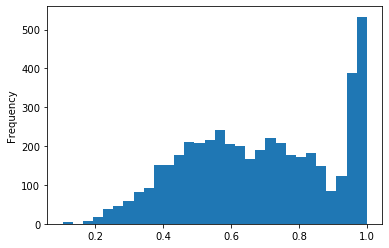

In [176]:
# Plot all values as a single distribution
res_df_ratio.stack().plot.hist(bins = 30)

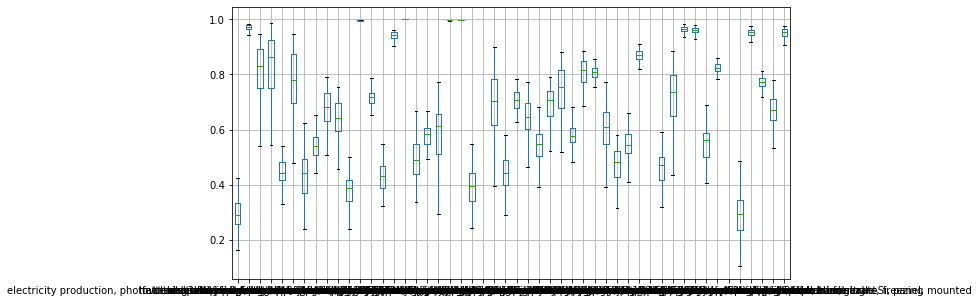

In [178]:
res_df_ratio.T.boxplot(figsize=(10,5), showfliers=False)

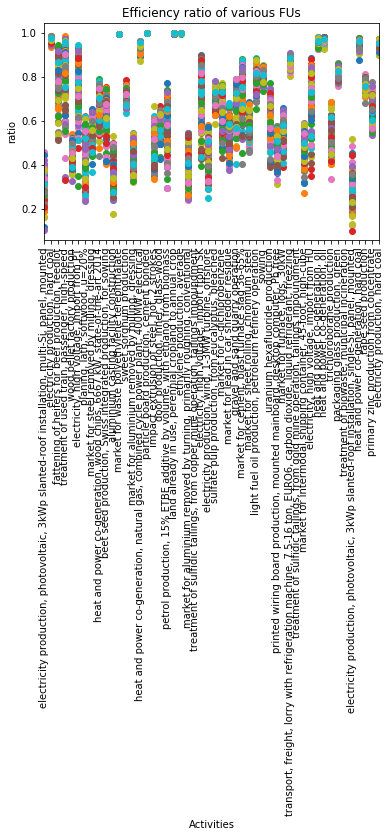

In [179]:
res_df_ratio.plot(kind='line', linestyle = 'none', marker = 'o', legend = None)
plt.title('Efficiency ratio of various FUs')
plt.ylabel('ratio')
plt.xlabel('Activities')
plt.xticks(rotation=90)
plt.xticks(range(0,len(res_df_ratio.index)), res_df_ratio.index, rotation=90)

plt.show()

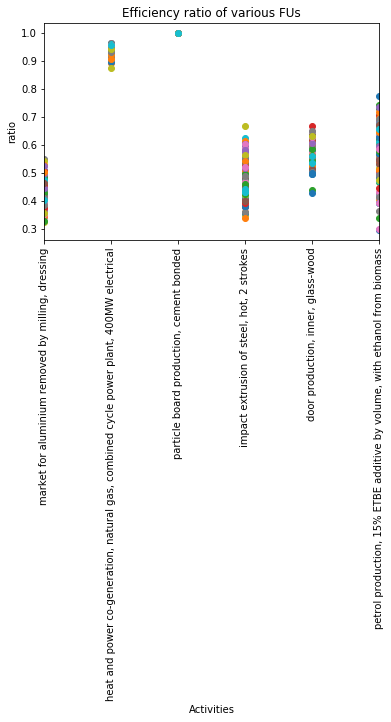

In [180]:
df = res_df_ratio.iloc[13:19,:]

df.plot(kind='line', linestyle = 'none', marker = 'o', legend = None)
plt.title('Efficiency ratio of various FUs')
plt.ylabel('ratio')
plt.xlabel('Activities')
plt.xticks(rotation=90)
plt.xticks(range(0,len(df.index)), df.index, rotation=90)

plt.show()

# Conclusions

We observe two non-linear effects. 

1) In the Part one of this notebook, we see how an artificial but linear efficiency improvement of selected activities results in a non-linear effect on the impact of such activities. Improving the efficiency of coal power plants reduces progressively the impact of e.g. elecricity production, but this effect is not directly proportional to the efficiency gain and is also depending on the activity under analysis, i.e. whether we consider electtricity production or another type of production).

2) in the second part of this notebook, we observe again how a random change of efficiencies for several transformation activities is reflected on the impact of several market activities. This effect is highly dependend on the activity under analysis, and no clear relationship can be identified between the change in efficiency and its effect, i.e. while this effect can be explained for single activities is not generalizable in a straightforward way at database level as each activity will behave differently and might be affected substantially even if the change occurs several step upstream in its life cycle.

Summing up, this means that the effect of upscaling specific activities, under the assumption that this upscaling returns higher efficiency, which is justified by literature, might have an unpredictable and non-linear effect on the impact of a product system and of related product systems. Unig datasets that are built using data from pilot scale activities and are not representative of the potential of such activities at large undustrial scale might thus skew results in unexpected ways.